# Relevant Libraries

In [1]:
# Importing Relevant Libraries
import os, os.path
import importlib
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import qmc
import pyDOE2 as pyd
import seaborn as sns
from matplotlib.pyplot import plot, savefig
import time
import datetime 
from datetime import date
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.ticker as mtick
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import logging
from pyomo.environ import *
import yaml
from pathlib import Path
from scipy.stats import entropy
from cmcrameri import cm # https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf


# Source: https://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import sys # Python "sys" documentation: https://docs.python.org/3/library/sys.html

# To reset the default parameters of matplotlib:
import matplotlib as mpl

In [ ]:
# To reset the default parameters of matplotlib:
mpl.rcParams.update(mpl.rcParamsDefault)

# Importing data

In [2]:
# ------------------ Parameters not imported/computed ------------------
i = ['BECCS', 'A/R', 'SCS', 'BC', 'DACCS', 'EW', 'OA', 'DOCCS']
k1 = 0 # Value of first time period
delK = 5 # Time step of optimisation (i.e., length of each period)
N = 4 # Number of segments for piecewise linear approximation
first_year = 2020 # Year corresponding to first time period
last_year = 2100 # Year corresponding to last time period
T = int(1 + (last_year-first_year)/delK) # Number of time periods evaluated, equivalent to 17 if delK = 5 (i.e., 80 years)
k = list(range(k1,T))

# Color Map for later plotting
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}

## Model input data

In [ ]:
futures_file = Path('PortfolioFiles\sample_of_futures\File Name_15.08.2024.xlsx')

df_input = pd.read_excel(futures_file, index_col ='future_id')

# Dataframe of sampled parameter, df_LHS, is found from df_input by removing the columns that have the same value for all rows
list_repeated = list(df_input[df_input.columns[df_input.nunique() <= 1]])
df_LHS = df_input.drop(list_repeated, axis=1)

# If only the Y_ref is wanted:
Initial_YRef = df_input[df_input.columns.intersection(['Yref_' + el for el in i])]
Initial_YRef.columns = [str(col).split('_')[1] for col in Initial_YRef.columns]
Initial_YRef = Initial_YRef.loc[0].to_dict()

n_lhs = len(df_LHS.T.index)-1 # "-1" because we added future 0 :)

df_LHS

## Model output data

In [3]:
#Reading aggregated results from csv:
output_file = 'PortfolioFiles/results_from_modelling/results_with_geo_10.12.2024.csv'

aggregated_results = pd.read_csv(output_file, index_col ='future_id')

# Separating input data from results: "aggregated_results = df_input + results" where "df_input = df_LHS + df_input_constant"
# Columns where all rows have the same values are input parameters not sampled
list_repeated = list(aggregated_results[aggregated_results.columns[aggregated_results.nunique() <= 1]])
df_LHS = aggregated_results.iloc[:,:aggregated_results.columns.get_loc(list_repeated[0])]
df_input = aggregated_results.iloc[:,:1+aggregated_results.columns.get_loc(list_repeated[-1])]

# If only the Y_ref is wanted:
Initial_YRef = df_input[df_input.columns.intersection(['Yref_' + el for el in i])]
Initial_YRef.columns = [str(col).split('_')[1] for col in Initial_YRef.columns]
Initial_YRef = Initial_YRef.loc[0].to_dict()

n_lhs = len(df_LHS.T.index)-1 # "-1" because we added future 0 :)

# Saving the [min, max] ranges of each metric in aggregated_results
all_metrics_ranges = {key: [] for key in aggregated_results.columns.to_list()}
for metric in aggregated_results.columns:
    all_metrics_ranges[metric].append([aggregated_results[metric].min(),aggregated_results[metric].max()])

total_future = aggregated_results[['Removals','Costs']]
max_resources = aggregated_results[['Land','Energy','Water','Nitrogen','Phosphorous']]   
max_capacity = aggregated_results[i]

removed_per_CDR = aggregated_results[aggregated_results.columns.intersection([el+'_removed' for el in i])]
removed_per_CDR.columns = [str(col).split('_')[0] for col in removed_per_CDR.columns]

max_2050 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2050 for el in i])].T
max_2050.index = [str(col).split('_')[0] for col in max_2050.index]

max_2075 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2075 for el in i])].T
max_2075.index = [str(col).split('_')[0] for col in max_2075.index]

max_2100 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2100 for el in i])].T
max_2100.index = [str(col).split('_')[0] for col in max_2100.index]

solved = aggregated_results.Solved.sum()

aggregated_results

,Energy_DACCS,Energy_DOCCS,Energy_EW,Energy_OA,EnergyL,Land_A/R,Land_BECCS,LandL,ER_A/R,ER_BC,...,OA_2100,DOCCS_2100,BECCS_removed,A/R_removed,SCS_removed,BC_removed,DACCS_removed,EW_removed,OA_removed,DOCCS_removed
future_id,,,,,,,,,,,,,,,,,,,,,
0,4.700,2.500,0.5,0.700,2030,0.07,0.040,200000000,-0.230,-0.050,...,6.982525e+08,0.0,2.730000e+07,1.500000e+11,3.300000e+10,1.050750e+10,1.725001e+11,2.000000e+10,1.396505e+10,10.0
1,4.700,8.300,12.5,4.767,2045,0.08,0.170,1000000000,-0.230,-0.033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.000,8.300,0.5,2.733,2045,0.08,0.170,600000000,-0.230,0.083,...,0.000000e+00,0.0,2.730000e+07,1.936792e+11,1.166000e+11,9.090750e+10,9.878603e+10,1.000000e+01,1.000000e+01,10.0
3,6.467,2.500,4.5,6.800,2030,0.07,0.170,400000000,-0.202,0.100,...,1.000000e+09,0.0,6.636388e+10,1.822000e+11,8.775000e+10,2.255075e+11,3.708048e+11,4.952163e+10,1.785220e+10,10.0
4,10.000,6.367,12.5,2.733,2030,0.07,0.040,600000000,-0.063,0.017,...,1.080000e+10,0.0,1.141955e+11,2.794000e+11,6.200000e+10,2.325750e+10,1.539638e+11,1.000000e+01,2.671831e+11,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,8.233,2.500,8.5,2.733,2030,0.09,0.105,700000000,-0.202,0.017,...,5.200000e+09,0.0,9.600568e+10,2.794000e+11,1.590000e+11,1.538075e+11,2.970480e+11,6.484983e+08,1.140903e+11,10.0
2997,6.467,2.500,12.5,0.700,2050,0.08,0.040,300000000,-0.174,-0.050,...,3.800000e+09,0.0,8.970591e+10,2.213269e+11,1.590000e+11,4.185750e+10,1.197776e+11,7.040105e+09,1.612920e+11,10.0
2998,10.000,6.367,0.5,4.767,2050,0.09,0.105,200000000,0.020,-0.017,...,1.220000e+10,0.0,2.730000e+07,1.624998e+11,1.000000e+11,3.900750e+10,1.487922e+10,1.081155e+10,1.727746e+11,10.0


In [4]:
with open('metric_names.yaml', 'r') as f:
    metric_names = yaml.safe_load(f)
    
all_metrics_names = metric_names['all_metrics_names']
all_metrics_units = metric_names['all_metrics_units']

metric_names

{'all_metrics_names': {'A/R': 'Maximum Capacity of AR',
  'A/R_2050': 'Maximum Capacity A/R by 2050',
  'A/R_2075': 'Maximum Capacity A/R by 2075',
  'A/R_2100': 'Maximum Capacity A/R by 2100',
  'A/R_removed': 'Removals delivered by A/R',
  'BC': 'Maximum Capacity of BC',
  'BC_2050': 'Maximum Capacity BC by 2050',
  'BC_2075': 'Maximum Capacity BC by 2075',
  'BC_2100': 'Maximum Capacity BC by 2100',
  'BC_removed': 'Removals delivered by BC',
  'BECCS': 'Maximum Capacity of BECCS',
  'BECCS_2050': 'Maximum Capacity BECCS by 2050',
  'BECCS_2075': 'Maximum Capacity BECCS by 2075',
  'BECCS_2100': 'Maximum Capacity BECCS by 2100',
  'BECCS_removed': 'Removals delivered by BECCS',
  'CDRRequired': 'Removals Required (2020 - 2100)',
  'Costs': 'Discounted Cumulative Costs',
  'DACCS': 'Maximum Capacity of DACCS',
  'DACCS_2050': 'Maximum Capacity DACCS by 2050',
  'DACCS_2075': 'Maximum Capacity DACCS by 2075',
  'DACCS_2100': 'Maximum Capacity DACCS by 2100',
  'DACCS_removed': 'Remova

# Entropy calculations

Uses 'entropy' from scipy.stats ([link to Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html))

entropy(pk, qk=None, base=None, axis=0, *, nan_policy='propagate', keepdims=False)

Calculate the Shannon entropy/relative entropy of given distribution(s).

- If only probabilities pk are given, the Shannon entropy is calculated as H = -sum(pk * log(pk)).

- If qk is not None, then compute the relative entropy D = sum(pk * log(pk / qk)). This quantity is also known as the Kullback-Leibler divergence. This routine will normalize pk and qk if they don’t sum to 1.

In [ ]:
def calculate_entropy_reduction(data, outcomes, input_parameters, outcome_bins=10):
    """
    Calculate entropy reduction of outcomes for each input parameter.
    Interpret the results as the input parameter’s contribution to reducing uncertainty in the outcomes.
    
    Parameters:
    - data: Pandas DataFrame, with rows as futures and columns as input parameters and outcomes.
    - outcomes: List of column names corresponding to outcome metrics.
    - input_parameters: List of column names corresponding to input parameters.
    - outcome_bins: Number of bins for discretizing continuous outcome parameters.
    
    Returns:
    - reduction_results: Dictionary with input parameters as keys and entropy reduction values as values.
    """
    # Initialising the results dictionaries 
    reduction_results = {}
    conditional_entropy_results = {}

    binned_data = data.copy()
    # Initialise the dictionary for calculating baseline entropy for each outcome
    baseline_entropy = {}
    '''
    # ============== a. THIS CODE USES A FIXED NUMBER OF BINS FOR ALL OUTCOMES ==============
    # Discretize continuous outcome parameters
    for outcome in outcomes:
        binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=outcome_bins, labels=False)

        # Calculate baseline entropy for each outcome
        values, counts = np.unique(binned_data[f'binned_{outcome}'], return_counts=True) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).
        probabilities = counts / counts.sum()
        baseline_entropy[outcome] = entropy(probabilities) # The Shannon entropy is calculated as H = -sum(pk * log(pk))'''
    
    
    # ============== b. THIS CODE USES A VARYING NUMBER OF BINS PER OUTCOME ==============
    for outcome in outcomes:
        bins = outcome_bins
        values = np.unique(data[outcome]) # Find the unique elements of an array (values)
        if len(values) <= 40: bins = outcome_bins/2 # For outcomes with low number of unique values, use less bins
        binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=math.ceil(len(values)/bins), labels=False) # Bin based on the number of unique elements
        values, counts = np.unique(binned_data[f'binned_{outcome}'], return_counts=True) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).
        probabilities = counts / counts.sum()
        baseline_entropy[outcome] = entropy(probabilities) # The Shannon entropy is calculated as H = -sum(pk * log(pk))

    # ============== REDUCTION OF ENTROPY ==============
    # Loop over input parameters to calculate entropy reduction
    for param in input_parameters:
        conditional_entropy = {outcome: 0 for outcome in outcomes}
        
        # Group data by the discrete values of the input parameter
        groups = binned_data.groupby(param)
        
        # Calculate weighted conditional entropy for each outcome
        for group_name, group in groups:
            group_weight = len(group) / len(binned_data)
            for outcome in outcomes:
                values, counts = np.unique(group[f'binned_{outcome}'], return_counts=True)
                probabilities = counts / counts.sum()
                group_entropy = entropy(probabilities)
                conditional_entropy[outcome] += group_weight * group_entropy
        
        # Calculate reduction in entropy for this parameter
        reduction_results[param] = {
            outcome: baseline_entropy[outcome] - conditional_entropy[outcome]
            for outcome in outcomes
        }
        conditional_entropy_results[param] = {outcome: conditional_entropy[outcome] for outcome in outcomes}
    
    return reduction_results, conditional_entropy_results


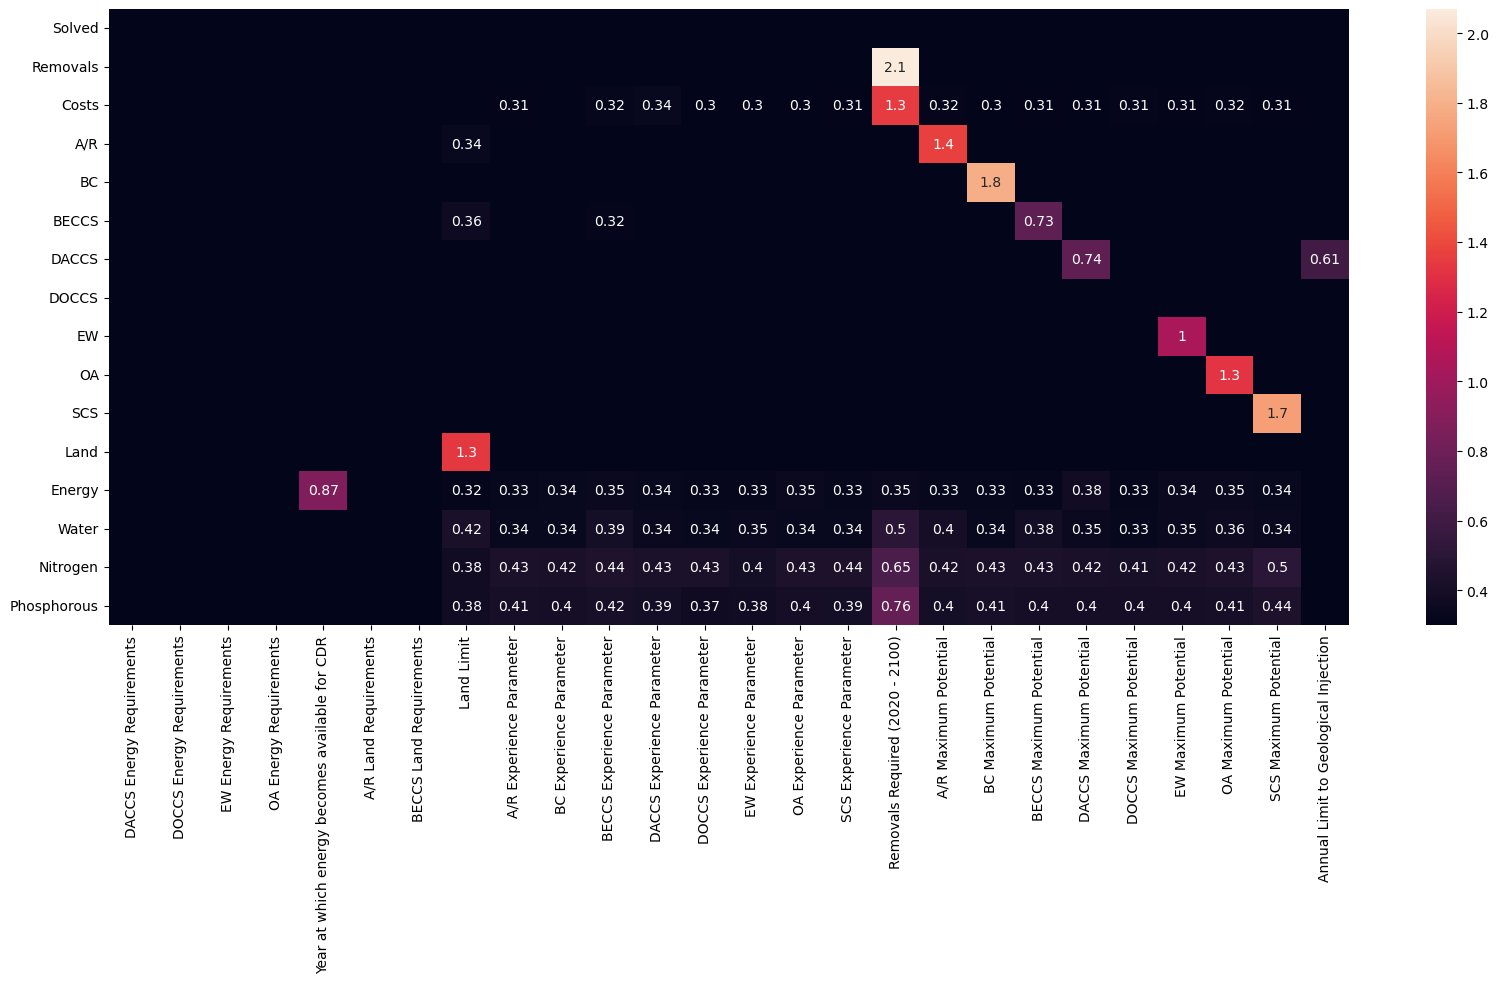

"\n# Discretize continuous outcome parameters\nbinned_data = data.copy()\nfor outcome in outcomes:\n    binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=outcome_bins, labels=False)\n\n# Calculate baseline entropy for each outcome\nbaseline_entropy = {}\nfor outcome in outcomes:\n    values, counts = np.unique(binned_data[f'binned_{outcome}'], return_counts=True) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).\n    print(outcome)\n    print('Values: ', values)\n    print('Counts: ', counts)\n    probabilities = counts / counts.sum()\n    print('Probabilities: ', probabilities)\n    print()"

In [54]:
# Example usage:
# data: DataFrame with "future_id" as index, input parameters and outcomes as columns.

data = aggregated_results.drop(list_repeated, axis=1) # We do not need the input parameters that were NOT sampled
data = data.dropna(axis='index') # Removed the parameters that were not solved
input_parameters = df_LHS.columns.to_list() # List of input parameters that were sampled
outcomes = data.drop(input_parameters, axis=1).columns.to_list() # Outcomes = all columns - sampled parameters

outcome_bins=10

reductions, conditional_entropy_results = calculate_entropy_reduction(data, outcomes[:16], input_parameters, outcome_bins=outcome_bins)

vmin= 0.3 # minimum value to show in plots 

#for d in [reductions, conditional_entropy_results]:
for d in [reductions]:
    data_to_plot = pd.DataFrame(d)
    data_to_plot = data_to_plot.rename(columns=all_metrics_names)

    plt.subplots(figsize=(20,8))
    #plt.suptitle('Reduction of entropy of outcome variables (rows) by input variables (columns) \n only values >0.2 shown for readibility', size=12, y=0.94)
    dataplot = sns.heatmap(data_to_plot, annot=True, vmin=vmin) # cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib

    for t in dataplot.texts: # How to annotate only valuea greater than x: https://stackoverflow.com/questions/66099438/how-to-annot-only-values-greater-than-x-on-a-seaborn-heatmap
        if float(t.get_text())>=vmin:
            t.set_text(t.get_text()) #if the value is greater than x then I set the text 
        else:
            t.set_text(" ")

    plt.show()
plt.close('all')
'''
# Discretize continuous outcome parameters
binned_data = data.copy()
for outcome in outcomes:
    binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=outcome_bins, labels=False)

# Calculate baseline entropy for each outcome
baseline_entropy = {}
for outcome in outcomes:
    values, counts = np.unique(binned_data[f'binned_{outcome}'], return_counts=True) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).
    print(outcome)
    print('Values: ', values)
    print('Counts: ', counts)
    probabilities = counts / counts.sum()
    print('Probabilities: ', probabilities)
    print()'''


In [53]:
'''
# Discretize continuous outcome parameters
binned_data = data.copy()
for outcome in outcomes:
    binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=outcome_bins, labels=False)'''


# Calculate baseline entropy for each outcome
binned_data = data.copy()
outcome_bins = 10

for outcome in outcomes:
    bins = outcome_bins
    print(outcome)
    values = np.unique(data[outcome]) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).
    print('Number of initial values: ', len(values))
    if len(values) <= 40: bins = outcome_bins/2

    binned_data[f'binned_{outcome}'] = pd.cut(data[outcome], bins=math.ceil(len(values)/bins), labels=False)
    values, counts = np.unique(binned_data[f'binned_{outcome}'], return_counts=True) # Find the unique elements of an array (values), and the number of times each unique item appears in the array (counts).

    print('Number of values: ', len(values))
    print('Counts: ', counts)
    probabilities = counts / counts.sum()
    print('Probabilities: ', probabilities)
    print()

Solved
Number of initial values:  1
Number of values:  1
Counts:  [2687]
Probabilities:  [1.]

Removals
Number of initial values:  36
Number of values:  8
Counts:  [375 374 374 372 349 316 286 241]
Probabilities:  [0.13956085 0.13918869 0.13918869 0.13844436 0.12988463 0.11760328
 0.10643841 0.08969111]

Costs
Number of initial values:  2687
Number of values:  194
Counts:  [ 3 21 46 66 58 49 47 46 38 26 32 27 38 53 50 50 32 37 39 29 38 35 29 36
 30 34 31 28 36 18 25 27 41 22 42 29 33 22 20 23 21 29 33 32 24 27 26 25
 16 20 15 14 32 20 15 27 20 15 17 20 22 18 17 18 23 30 14 21 13 13 17 19
 17  9 12 16 14 13 12 12 14 16 11 14 18 10 13 11 18 14 11 12 16 10  8 12
 10 14  8 10  9  6  8  7  6  8  3  6  9  6  6  2  3  4  8  8  4  3  4  7
  6  3  4  8  4  2  5  1  6  3  7  2  6  3 10  6  4  1  5  1  3  1  2  1
  3  1  4  1  1  1  1  1  3  1  2  1  1  1  1  1  2  3  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1]
Probabilities:  [0.00111649 0.00